<a href="https://colab.research.google.com/github/jakubtwalczak/Muller_Guido_Introduction_to_ML/blob/main/Rozdzia%C5%82_5_Ocena_i_doskonalenie_modelu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wstęp.

Do tej pory, aby ocenić nadzorowane modele, wykonywaliśmy następującą sekwencję operacji:
1. Dzieliliśmy zbiór danych na zbiór uczący i testowy przy pomocy funkcji train_test_split,
2. Budowaliśmy model na zbiorze uczącym, przy pomocy metody fit,
3. Ocenialiśmy predykcje modelu przy pomocy metody score na zestawie testowym.

Przykładowo:

In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = make_blobs(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression().fit(X_train, y_train)
print(f"Test score: {logreg.score(X_test, y_test)}")

Test score: 0.88


Celem dzielenia danych przy pomocy train_test_split jest potrzeba zmierzenia, jak dobrze model uogólnia na nieznanych wcześniej danych. Nie interesuje nas raczej wydajność uczenia, a to, jak model zachowuje się w stosunku do danych, których wcześniej nie poznał.

# Walidacja krzyżowa.

Jest to metoda statystyczna, pozwalająca oceniać wydajność uogólniania, bardziej stabilna niż zwykły podział na zbiory uczący i testowy. Dane dzielone są wielokrotnie i trenowane przez wiele modeli. Najczęściej stosuje się k-krotną walidację krzyżową, gdzie k to liczba określona przez użytkownika (najczęściej 5 lub 10). Dane dzielone są na k równych części, na których po kolei trenowany jest model; za pierwszym razem trenowany jest przy użyciu pierwszego podzbioru jako testowego i pozostałych jako uczących. Dokładność oceniana jest na pierwszym podzbiorze. Za drugim razem jest testowany na drugim podzbiorze i uczony na pozostałych itd., aż do wyczerpania wszystkich podzbiorów. Proces jest zilustrowany przez poniższy wykres.

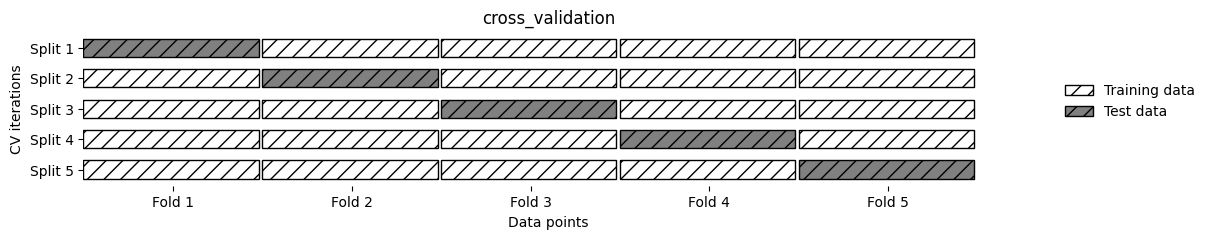

In [2]:
import mglearn

mglearn.plots.plot_cross_validation()

## Walidacja krzyżowa w scikit-learn.

Walidacja krzyżowa (lub kroswalidacja) jest zaimplementowana w funkcji cross_val_score. Parametrami są: model podlegający ocenie, dane treningowe i etykiety prawdy podstawowej.

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(max_iter=1000)

scores = cross_val_score(logreg, iris.data, iris.target)
print(f"Cross-validation scores: {scores}")

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


Domyślnie funkcja przeprowadza potrójną walidację krzyżową i zwraca pięć wartości dokładności. Można zmienić liczbę używanych podzbiorów - parametr cv.

In [4]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=10)
print(f"Cross-validation scores: {scores}")

Cross-validation scores: [1.         0.93333333 1.         1.         0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]


Powszechnym sposobem podsumowania dokładności walidacji krzyżowej jest obliczenie średniej. Na podstawie poniższego wyniku możemy stwierdzić, że dokładność modelu wynieść powinna ok. 0,97, jednak istnieje rozbieżność w dokładności między podzbiorami - od 0,93 do 1,00. Może to być zarówno konsekwencją niedużego zbioru danych, jak i ewentualnej zależności modelu od poszczególnych podzbiorów.

In [5]:
print(f"Mean cross-validation score: {scores.mean():.3f}")

Mean cross-validation score: 0.973


Zalety walidacji krzyżowej:
- każdy przykład danych znajduje się tylko w jednym podzbiorze, więc unikamy sytuacji, w której "trudne" dane znajdą się tylko w zbiorze treningowym; aby wynik walidacji krzyżowej był wysoki, model musi uogólniać dobrze wszystkie próbki,
- duża wartość informacyjna nt. tego, jak wrażliwy jest model na wybór danych uczących (tj. jakiej dokładności można się spodziewać w najgorszym i najlepszym scenariuszu),
- bardziej efektywne wykorzystanie danych; wydzielenie z całości danych zbioru testowego daje z reguły stosunkowo mniejszą liczbę danych treningowych niż każda iteracja kroswalidacji.

Główna wada - zwiększone koszty obliczeniowe.

Ważne - kroswalidacja nie zwraca modelu; podczas wywołania funkcji cross_val_score tworzy się wiele modeli, ale jej celem jest jedynie ocena uogólniania algorytmu na konkretnych zbiorze danych.

## Stratyfikowana k-krotna walidacja krzyżowa i in. strategie.

Dzielenie danych na k podzbiorów poprzez rozpoczęcie od pierwszej k-tej części danych nie zawsze jest dobrym pomysłem. Przykładem na to może być zbiór danych Iris.

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()
print(f"Iris labels:\n{iris.target}")

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


1/3 danych początkowych to klasa 0, następna 1/3 - klasa 1, ostatnia część - klasa 2. Kroswalidacja z trzema podzbiorami byłaby niemiarodajna; pierwszy podział zawierałby tylko próbki 0 w zbiorze testowym, a zbiór uczący składałby się wyłącznie z próbek 1 i 2 itd. Doprowadziłoby to do tego, że dokładność wyniosłaby 0, ponieważ model nie znałby próbek klasy 0 i nie byłby w stanie wobec nich generalizować.

Prosta strategia k-krotna zawodzi w tym wypadku. Dlatego na potrzeby klasyfikacji biblioteka Scikit-learn zapewnia możliwość skorzystania ze stratyfikowanej k-krotnej walidacji krzyżowej. Dzielimy dzięki niej dane tak, żeby proporcje między klasami były identyczne w całym zbiorze danych, jak i poszczególnych podzbiorach. Jeżeli 80% próbek w danych należy do klasy 0, a 20% do klasy 1, stratyfikowana k-krotna kroswalidacja zapewnia, że w każdym podziale danych 80% próbek przynależy do klasy 0, a 20% - do klasy 1.

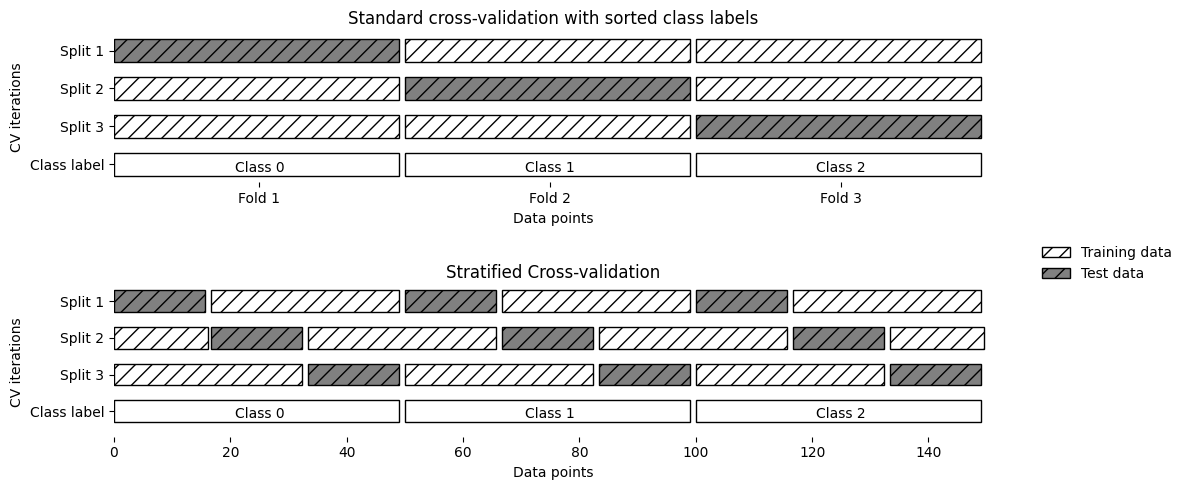

In [7]:
mglearn.plots.plot_stratified_cross_validation()

Użycie tej metody przy zadaniu klasyfikacji jest lepszym pomysłem niż zwykła kroswalidacja k-krotna. Daje ona bardziej wiarygodne oszacowanie wydajności uogólniania, szczególnie jeżeli jedna z klas jest mniej licznie reprezentowana w danych.

W przypadku regresji Scikit-learn domyślnie używa standardowej walidacji krzyżowej k-krotnej. Można oczywiście spróbować, aby każdy podzbiór był reprezentatywny dla różnych wartości celów regresji, ale jest to rzadko używana strategia.

Biblioteka Scikit-learn pozwala na lepszą kontrolę nad dzieleniem danych w ramach walidacji krzyżowej, przede wszystkim za pośrednictwem parametru cv. W większości przypadków skuteczne jest zastosowanie ww. metod (w odpowiednich zadaniach) z domyślnymi parametrami, ale są przypadki, w których można chcieć wykorzystać inną strategię.

Np. załóżmy sytuację, gdy chcemy odtworzyć wyniki kogoś innego i używamy w tym celu standardowej k-krotnej walidacji krzyżowej na zbiorze danych do klasyfikacji. Aby to zrobić, trzeba zaimportować rozdzielającą klasę KFold i utworzyć jej instancję z liczbą podzbiorów, których chcemy użyć.

In [8]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

Następnie możemy obiekt rozdzielacza przekazać jako parametr cv do funkcji cross_val_score.

In [9]:
print(f"Cross-validation scores:\n{cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")

Cross-validation scores:
[1.         1.         0.86666667 0.93333333 0.83333333]


Możemy w ten sposób zweryfikować podniesione wcześniej twierdzenie, że zastosowanie potrójnej niestratyfikowanej kroswalidacji w zbiorze Iris nie jest dobrym pomysłem.

In [10]:
kfold = KFold(n_splits=3)
print(f"Cross-validation scores:\n{cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")

Cross-validation scores:
[0. 0. 0.]


Innym sposobem rozwiązania tego problemu, zamiast stratyfikacji podzbiorów, jest tasowanie danych, aby ułożyć próbki w losowej kolejności wg etykiety. Ustawiamy parametr shuffle=True. Ponadto, by tasowanie było powtarzalne, ustawiamy parametr random_state, aby uzyskiwać za każdym razem ten sam wynik. Tasowanie danych przez ich podzieleniem daje znacznie lepszy wynik walidacji krzyżowej.

In [11]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print(f"Cross-validation scores:\n{cross_val_score(logreg, iris.data, iris.target, cv=kfold)}")

Cross-validation scores:
[0.98 0.96 0.96]


Inną metodą jest walidacja krzyżowa z pominięciem (leave one out). Jest to k-krotna walidacja krzyżowa, w której każda krotność jest pojedynczą próbką - dla każdego podziału zbiór testowy jest jednoelementowy i składa się z jednej próbki danych. Może to się okazać bardzo czasochłonne w przypadku dużych zbiorów danych, ale czasem zapewnia lepsze oszacowania dla mniejszych zbiorów.

In [12]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print(f"Number of cv iterations: {len(scores)}")
print(f"Mean accuracy: {scores.mean():.2f}")

Number of cv iterations: 150
Mean accuracy: 0.97


Inną, bardzo elastyczną strategią jest walidacja krzyżowa z podziałem losowym (shuffle-split). Każdy podział sporządzony przy pomocy tej metody przydziela określoną część zbioru danych do zbioru uczącego i określoną część do zbioru testowego, a podział ten jest sporządzany n razy.

Poniżej wizualiacja procesu czterech iteracji dzielenia zbioru danych składającego się z dziesięciu punktów, ze zbiorem uczącym złożonym z 5 punktów i zbiorami testowymi po 2 punkty każdy.

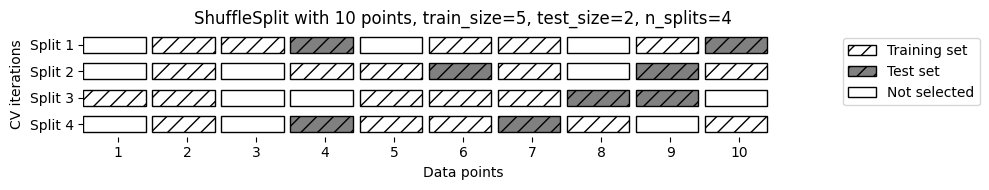

In [13]:
mglearn.plots.plot_shuffle_split()

Podzielmy więc zbiór danych na pół w dziesięciu iteracjach.

In [14]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print(f"Cross-validation scores:\n{scores}")

Cross-validation scores:
[0.94666667 0.97333333 0.92       0.93333333 0.93333333 0.96
 0.97333333 0.94666667 0.98666667 0.96      ]


Walidacja krzyżowa z losowym podziałem pozwala na kontrolę liczby iteracji niezależnie od rozmiaru zbioru treningowego i testowego, a także użycie w każdej iteracji tylko części danych, jeżeli suma ustawionych wartości parametrów train_size i test_size jest mniejsza niż 1. Może mieć to dużą przydatność, gdy pracujemy z dużym zbiorem danych.

Istnieje również stratyfikowany wariant - StratifiedShuffleSplit, który dostarczyć może bardziej wiarygodnych wyników dla zadań klasyfikacyjnych.

Innym powszechnie stosowanym rozwiązaniem jest walidacja krzyżowa z grupami. W danych mogą znajdować się silnie powiązane ze sobą grupy. Np. chcemy zbudować system rozpoznawania emocji na podstawie zdjęć twarzy; posiadamy zbiór danych obejmujący 100 zdjęć, na których każda osoba jest uchwycona wielokrotnie, a jej twarz prezentuje różne emocje. Przy domyślnej warstwowej walidacji krzyżowej możliwe jest, że zdjęcia tej samej osoby znajdą się w zbiorze treningowym i testowym, a więc modelowi nie będzie zapewniona odpowiednia różnorodność danych twarzy, a tym samym nie nauczy się dobrze uogólniać. Aby dokładnie ocenić uogólnianie z użycie nowych twarzy, musimy się upewnić, że dane uczące i testowe zawierają zdjęcia różnych osób.

Możemy w tym celu użyć klasy GroupKFold, która jako argument przyjmuje tablicę groups. Tablica ta wskazuje grupy w danych, które nie powinny być dzielone podczas tworzenia zestawów uczących i testowych ani mylone z etykietą klasy. Takie zastosowanie jest powszechne w zastosowaniach medycznych (np. możemy mieć dużo próbek od tego samego pacjenta, ale chcemy uogólniać na innych pacjentów), czy też w rozpoznawaniu mowy.

Użyjmy syntetycznego zbioru danych z grupowaniem podanym przez tablicę groups. Zbiór składa się z 12 punktów danych, a dla każdego z nich groups określa, do której grupy należy punkt. W poniższym przykładzie tablica groups podaje, że istnieją cztery grupy.

In [15]:
from sklearn.model_selection import GroupKFold
X, y = make_blobs(n_samples=12, random_state=0)
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups=groups, cv=GroupKFold(n_splits=3))
print(f"Cross-validation scores:\n{scores}")

Cross-validation scores:
[0.75       0.6        0.66666667]


Poniższy wykres prezentuje, jak podziały są obliczane wg etykiet. Dla każdego podziału grupa należy w całości albo dla zbioru treningowego, albo testowego (nie zawsze są one posortowane, jak na poniższej ilustracji).

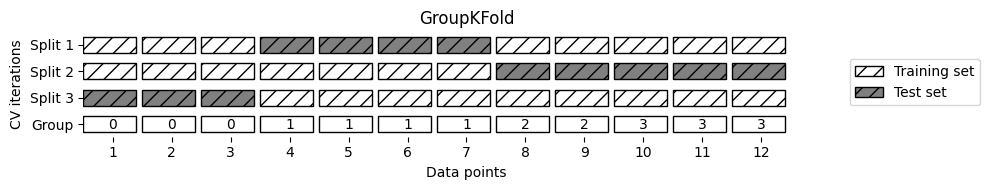

In [16]:
mglearn.plots.plot_group_kfold()

Scikit-learn zawiera jeszcze więcej strategii podziału dla walidacji krzyżowej. Powyżej zostały jednak omówione najbardziej popularne z nich.

# Przeszukiwanie siatki.

Znalezienie wartości ważnych parametrów modelu jest trudnym, ale zawsze niezbędnym zadaniem. Scikit-learn zawiera metody, które są w tym pomocne. Najczęściej stosowaną jest przeszukiwanie siatki - wypróbowanie wszystkich możliwych kombinacji wskazanych parametrów i zaimplementowanie najbardziej wydajnej. Załóżmy, że dla modelu SVM próbujemy po sześć różnych wartości gamma i C. Daje to siatkę 6 x 6, a więc 36 możliwych kombinacji parametrów.

Możemy samodzielnie zaimplementować proste przeszukiwanie siatki - wystarczy pętla z dwoma parametrami, uczeniem i oceną algorytmu dla każdej kombinacji.

In [17]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print(f"Size of training set: {X_train.shape[0]}")
print(f"Size of test set: {X_test.shape[0]}")
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print(f"Best score: {best_score}")
print(f"Best parameters: {best_parameters}")

Size of training set: 112
Size of test set: 38
Best score: 0.9736842105263158
Best parameters: {'C': 100, 'gamma': 0.001}


Możemy na podstawie ww. wyniku pokusić się o założenie, że znaleźliśmy model o dokładności ponad 97%. Twierdzenie to może być jednak błędne - jedynie znaleźliśmy kombinację parametrów z największą dokładnością w zbiorze testowym, niekoniecznie jednak przenoszącą się na nowe dane. Ponieważ wykorzystaliśmy dane testowe do dostosowania parametrów, nie możemy używać ich do oceny modelu. Potrzebujemy więc niezależnego zbioru danych, który posłuży do oceny, a nie został użyty do stworzenia modelu.

Jednym ze sposobów na rozwiązanie tego problemu jest ponowne podzielenie danych. Dysponować będziemy teraz trzema zbiorami: treningowym do uczenia modelu, walidacyjnym do doboru parametrów modelu i testowym do oceny wydajności wybranych parametrów.

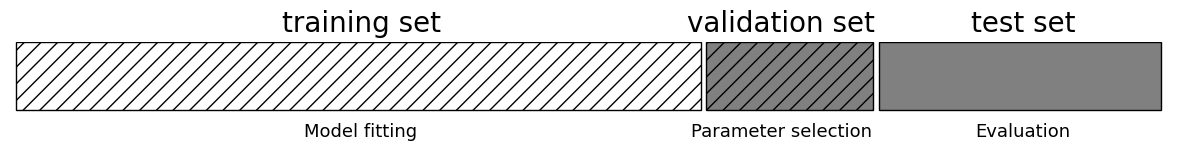

In [18]:
mglearn.plots.plot_threefold_split()

Po wybraniu najlepszych parametrów za pomocą zbioru walidacyjnego możemy przebudować model przy użyciu znalezionych ustawień parametrów. Model uczymy jednak zarówno na danych uczących, jak i walidacyjnych, więc w ten sposób do zbudowania modelu możemy użyć jak najwięcej danych.

In [19]:
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print(f"Size of training set: {X_train.shape[0]}")
print(f"Size of validation set: {X_valid.shape[0]}")
print(f"Size of test set: {X_test.shape[0]}")
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print(f"Best score on validation set: {best_score}")
print(f"Best parameters: {best_parameters}")
print(f"Test set score with best parameters: {test_score}")

Size of training set: 84
Size of validation set: 28
Size of test set: 38
Best score on validation set: 0.9642857142857143
Best parameters: {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.9210526315789473


Najlepszy wynik w zestawie walidacyjnym to 0,96 - nieznacznie niższy niż poprzednio, prawdopodobnie dlatego, że do uczenia użytych było mniej danych (z powodu potrzeby wydzielenia zbioru walidacyjnego). Wynik w zbiorze testowym jest jeszcze niższy - wynosi 0,92. Można więc stwierdzić, że nowe dane są klasyfikowane w 92% poprawnie, a nie 97%, jak wyglądało to przy pierwszym przeszukaniu siatki.

Rozróżnienie między zbiorem treningowym, walidacyjnym i testowym jest fundamentalne przy stosowaniu uczenia maszynowego w praktyce. Wszelkie wybory dokonane na podstawie informacji o dokładności modelu w zbiorze testowym "przepuszczają" informacje ze zbioru testowego do modelu. Dlatego tak ważne jest, żeby zbiór testowy zachować tylko do oceny modelu, a analizę eksploracyjną i dobór parametrów wykonywać przy użyciu kombinacji zbioru uczącego i walidacyjnego.

## Przeszukiwanie siatki z walidacją krzyżową.

Opisywana wyżej metoda, choć często używana, wykazuje sporą wrażliwość na to, jak podzielone są dane. Aby lepiej oszacować wydajność uogólniania, można zamiast pojedynczego podziału na zestaw uczący i walidacyjny użyć kroswalidacji do oceny wydajności wszystkich kombinacji parametrów.

Poniżej implementacja takiego rozwiązania.

In [20]:
import numpy as np

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        score = np.mean(scores)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print(f"Best score on validation set: {best_score}")
print(f"Best parameters: {best_parameters}")

Best score on validation set: 0.9731225296442687
Best parameters: {'C': 10, 'gamma': 0.1}


By za pomocą pięciokrotnej walidacji krzyżowej ocenić dokładność modelu SVM przy ww. wartościach parametrów, musielibyśmy wytrenować 5 x 36 = 180 modeli, a to jest bardzo czasochłonne.

Na poniższym wykresie zaprezentowano sposób wyboru najlepszych parametrów przy powyższej implementacji.

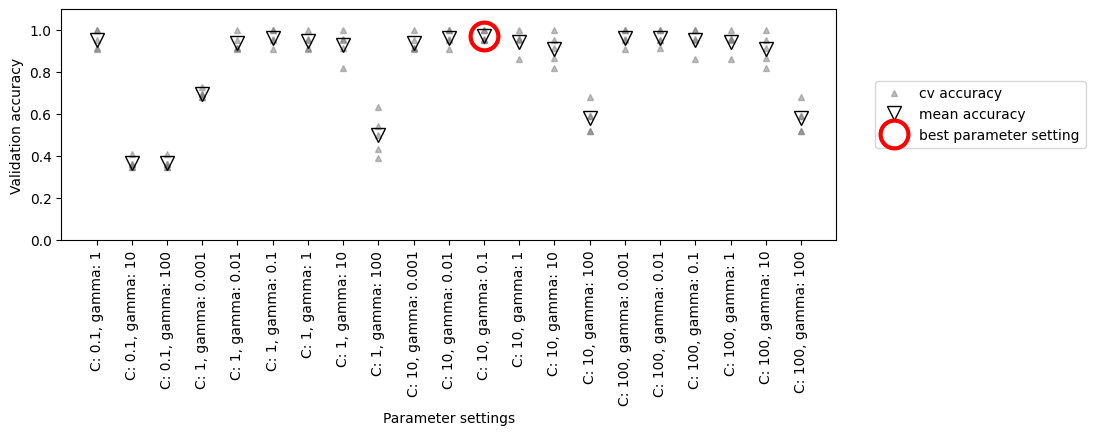

In [21]:
mglearn.plots.plot_cross_val_selection()

Dla każdego ustawienia parametru liczone jest pięć wartości dokładności (po jednej dla każdego podziału w ramach kroswalidacji), a potem liczona jest średnia dokładność walidacji dla każdej kombinacji. Wybierane są parametry o najwyższej średniej.

Walidacja krzyżowa wprawdzie jest w sensie ścisłym sposobem na ocenę danego algorytmu na określonych danych, ale często stosuje się ją w połączeniu z metodami wyszukiwania parametrów, jak przeszukiwanie siatki. Ogólny proces dzielenia danych, przeszukiwania siatki i oceny końcowych parametrów przedstawiony jest poniżej.

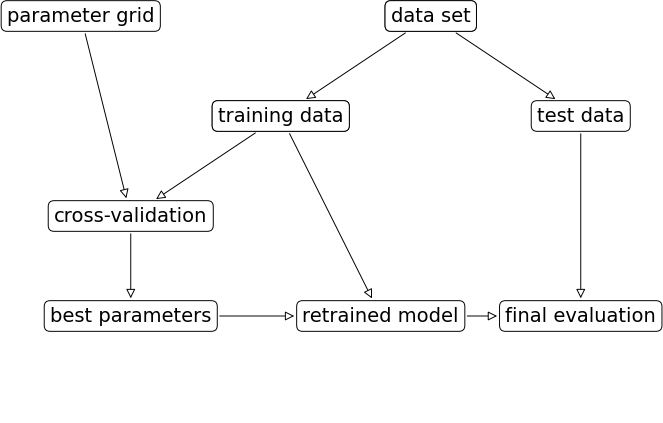

In [22]:
mglearn.plots.plot_grid_search_overview()

Biblioteka Scikit-learn udostępnia klasę GridSearchCV, którą zaimplementowano w postaci estymatora. Aby jej użyć, należy wskazać w słowniku wskazać parametry do przeszukania. Klucze słownika to nazwy parametrów, wartościami są ustawienia parametrów do dostosowania.

In [23]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print(f"Grid of parameters: {param_grid}")

Grid of parameters: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


Teraz możemy utworzyć instancję klasy GridSearchCV z modelem, siatką parametrów i strategią walidacji krzyżowej.

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

Obiekt ten zamiast podziału na zbiór uczący i walidacyjny użyje walidacji krzyżowej, jednak nie zwalnia nas to z potrzeby podziału zbiorów na treningowy i testowy, celem uniknięcia nadmiernego dopasowania. Utworzony i przypisany przez nas do zmiennej obiekt zachowuje się jak estymator, tak więc możemy wywołać standardowe metody fit, predict i score. Uruchomienie metody fit spowoduje uruchomienie walidacji krzyżowej dla każdej kombinacji parametrów.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

Dopasowanie ww. obiektu wyszukuje najlepsze parametry, ale również automatycznie dopasowuje model do danych uczących z tymi parametrami. Aby ocenić, jak dobrze model uogólnia przy pomocy najlepszej wybranej kombinacji, możemy wywołać metodę score w zbiorze testowym.

In [26]:
print(f"Test set score: {grid_search.score(X_test, y_test)}")

Test set score: 0.9736842105263158


Znaleźliśmy model, który osiąga 0,97 dokładności w zbiorze testowym. Do wyboru parametrów nie użyliśmy jednak zbioru testowego. Znalezione parametry przechowywane są w atrybucie best_params_, zaś najlepsza dokładność kroswalidacji - w atrybucie best_score_.

In [27]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score: 0.9731225296442687


Czasem pomocny może się okazać dostęp dokładnie modelu, który został znaleziony, aby przyjrzeć się współczynnikom lub ważności cech. Ten przechowywany jest w atrybucie best_estimator_. Ponieważ sam obiekt klasy GridSearchCV zawiera metody predict i score, użycie atrybutu best_estimator_ nie jest potrzebne do prognozowania i oceny modelu.

In [28]:
print(f"Best estimator:\n{grid_search.best_estimator_}")

Best estimator:
SVC(C=10, gamma=0.1)


## Analiza wyniku walidacji krzyżowej.

Zrozumienie związku zdolności modelu do generalizacji z wyszukanymi parametrami wymaga często wizualizacji wyników walidacji krzyżowej. Zacząć możemy od niedużej siatki, gdyż jak zaznaczono wyżej, jej przeszukanie jest dość kosztowne obliczeniowo. Potem możemy sprawdzić wyniki wyszukiwania w siatce, którą poddawaliśmy walidacji oraz - ewentualnie - rozszerzyć wyszukiwanie.

Wyniki przeszukiwania siatki znajdziemy w atrybucie cv_results_. Ma on postać słownika przechowującego wszystkie aspekty przeszukiwania.

In [29]:
import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
pd.set_option('display.max_columns', None)
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001818,0.000438,0.001263,0.000264,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.001334,0.000038,0.000908,0.000037,0.001,0.010,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.001336,0.000025,0.000902,0.000005,0.001,0.100,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.001349,0.000017,0.000912,0.000027,0.001,1.000,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.001394,0.000098,0.000965,0.000063,0.001,10.000,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


Wiersze w wynikach wyszukiwania (po przekonwertowaniu słownika na DataFrame) odpowiadają kolejnym ustawieniom parametrów. Dla każdego ustawienia przechowywane są wyniki, średnia i odchylenie standardowe wszystkich podziałów w ramach walidacji krzyżowej. Zobrazujmy średnie wyniki przy użyciu mapy cieplnej (heatmap).

Text(50.722222222222214, 0.5, 'C')

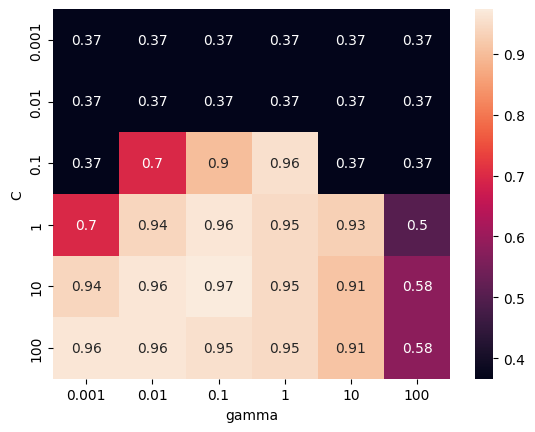

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

scores = np.array(results['mean_test_score']).reshape(6, 6)
sns.heatmap(scores, xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], annot=True)
plt.xlabel('gamma')
plt.ylabel('C')

Każdy punkt na mapie odpowiada jednej kombinacji parametrów. Kolory bardzo jasne oznaczają wysoką dokładność, im ciemniejsze są, tym dokładność jest niższa. Model SVC okazał się bardzo wrażliwy na tuning parametrów. Parametr C chociaż w każdej konfiguracji dał wynik poniżej 0,4, gdy ustawiony był na 0,01. Zakresy wybrane dla parametrów to takie, w których widać znaczące zmiany wyniku. Są one wystarczająco duże, gdyż optymalne wartości nie znajdują się na krawędziach.

Poniżej zobaczyć możemy przykłady nieodpowiednio dobranych zakresów wyszukiwania.

Text(0.04, 0.5, 'C')

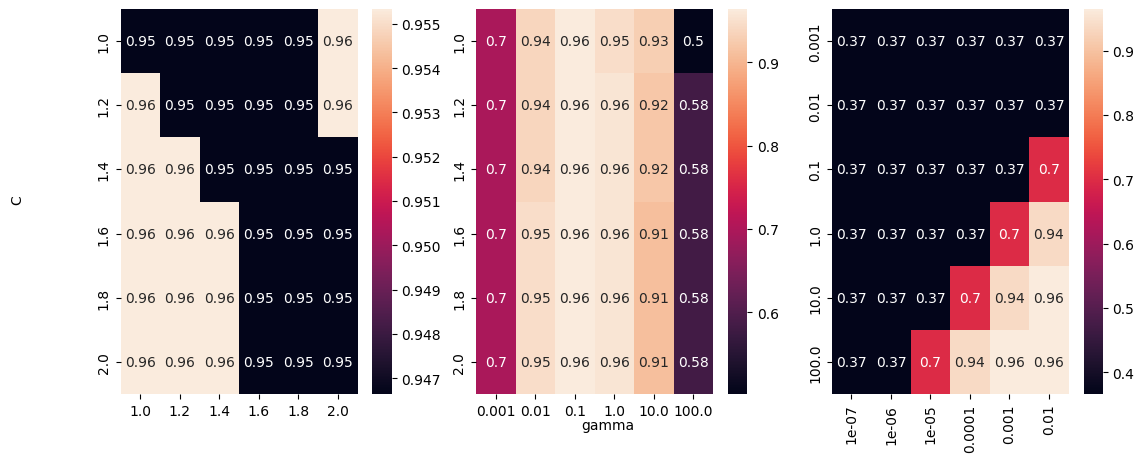

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
param_grid_linear = {'C': np.linspace(1, 2, 6), 'gamma': np.linspace(1, 2, 6)}
param_grid_one_log = {'C': np.linspace(1, 2, 6), 'gamma': np.logspace(-3, 2, 6)}
param_grid_range = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-7, -2, 6)}
for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)
    sns.heatmap(scores, xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], ax=ax, annot=True)

fig.text(0.5, 0.04, 'gamma', ha='center')
fig.text(0.04, 0.5, 'C', va='center', rotation='vertical')

W siatce pierwszej widać raptem dwa stałe kolory w całej siatce parametrów. Może to sugerować albo, że zakres parametrów i ich skalowanie są niewłaściwe, albo że parametr jest nieistotny. Dobrze jest zazwyczaj wypróbować skrajne wartości celem sprawdzenia, czy wskutek zmiany parametrów wystąpiły jakiekolwiek zmiany w dokładności.

Druga siatka prezentuje wzór w postaci pionowych linii, co prowadzi do wniosku, że tylko ustawienie parametru gamma ma znaczenie. Może to oznaczać, że parametr gamma dotyczy interesujących wartości, a parametr C nie lub nie jest ważny.

Na trzeciej siatce widzimy zmiany dla obu parametrów, jednym w lewym górnym rogu siatki nie dzieje się nic interesującego. Można z tego wywnioskować, że warto wykluczyć bardzo małe wartości z przyszłych przeszukiwań. Optymalnym ustawieniem parametru jest ustawienie w prawym dolnym rogu. Ponieważ optimum znajduje się na granicy siatki, można się spodziewać, że poza tą granicą znajdują się jeszcze lepsze wartości. Z tego powodu możemy chcieć zmienić w przyszłości zakres wyszukiwania, aby wziąć pod uwagę więcej parametrów w tym regionie.

## Przeszukiwanie przestrzeni niebędących siatkami.

Są przypadki, gdy przeszukiwanie wszystkich możliwych kombinacji parametrów nie jest dobrym pomysłem. Np. klasa SVC przyjmuje parametr kernel. W zależności od wyboru kernela (jądra) istotne będą różne parametry. Kernel "linear" oznacza, że model będzie liniowy i używany będzie tylko parametr C. Dla kernela "rbf" używane są parametry C i gamma, ale np. stopień. Przeszukiwanie wszystkich możliwych kombinacji C, gamma i kernel nie będzie miało sensu, bowiem kernel "linear" nie korzysta z parametru gamma.

Klasa GridSearchCV pozwala przekazać jako parametr listę słowników. Każdy element listy jest rozszerzany do niezależnej siatki.

In [32]:
param_grid = [
    {'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ]

print(f"Grid of parameters: {param_grid}")

Grid of parameters: [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


W pierwszej siatce wartość parametru kernel jest listą jednoelementową z parametrem "rbf", zmieniane są parametry C i gamma. W drugiej siatce również wartość dla klucza "kernel" jest listą z jednym elementem - tylko że "linear". Przez takie ustawienie kernela dopasowujemy tylko parametr C.

In [33]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.9731225296442687


Zajrzyjmy do atrybutu cv_results_. Jeżeli jądro jest typu "linear", zmienia się tylko parametr C.

In [34]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.001745,0.001282,0.001288,0.001273,0.001356,0.001481,0.001289,0.001355,0.001285,0.001344,0.001566,0.001568,0.001326,0.00135,0.001275,0.001232,0.001311,0.001479,0.00134,0.001204,0.001063,0.001943,0.001512,0.001647,0.001578,0.001151,0.001065,0.001176,0.001474,0.001667,0.001005,0.001016,0.001134,0.001315,0.001787,0.001809,0.001394,0.001223,0.001103,0.001032,0.001042,0.00119
std_fit_time,0.00048,0.00004,0.000041,0.00002,0.00006,0.000063,0.000023,0.000055,0.000026,0.000073,0.000338,0.000178,0.00004,0.000105,0.000155,0.000031,0.000018,0.000046,0.000035,0.000062,0.000026,0.000835,0.000032,0.00004,0.000625,0.000104,0.000028,0.000054,0.000023,0.000111,0.000002,0.000047,0.000025,0.000036,0.000147,0.000047,0.000056,0.00003,0.000042,0.000027,0.000025,0.000132
mean_score_time,0.001119,0.000879,0.000872,0.000871,0.001063,0.00096,0.000928,0.000962,0.000894,0.000901,0.001064,0.000949,0.000903,0.000893,0.000907,0.000886,0.000881,0.000918,0.000979,0.000895,0.000837,0.001589,0.000907,0.000982,0.001051,0.00089,0.000903,0.000842,0.000883,0.000958,0.000823,0.000902,0.000929,0.000951,0.001015,0.001055,0.000884,0.000851,0.000853,0.000824,0.000876,0.000874
std_score_time,0.000311,0.000018,0.000014,0.000008,0.000248,0.000032,0.00009,0.000089,0.000029,0.000046,0.000281,0.000037,0.000016,0.000033,0.000036,0.000029,0.000007,0.000016,0.000117,0.000022,0.000009,0.000651,0.000022,0.000024,0.000189,0.000038,0.000107,0.000024,0.000016,0.000051,0.000016,0.00008,0.000025,0.000033,0.000015,0.000039,0.000032,0.000013,0.000032,0.000038,0.000101,0.000036
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,10.0,10.0,10.0,100.0,100.0,100.0,100.0,100.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0
param_gamma,0.001,0.01,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0,0.001,0.01,0.1,1.0,10.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 10, 'kernel': 'rbf'}","{'C': 10, 'gamma': 100, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","

Uwaga dodatkowa: klasa GridSearchCV domyślnie używa dla klasyfikacji k-krotnej walidacji krzyżowej stratyfikowanej i dla regresji k-krotnej walidacji krzyżowej. Można jednak, jako parametr cv, przekazać obiektowi tej klasy dowolny rozdzielacz do kroswalidacji spośród tych, o których mowa była w sekcji "Stratyfikowana k-krotna walidacja krzyżowa i in. strategie".

## Zagnieżdżona walidacja krzyżowa.

Używając klasy GridSearchCV, nadal mamy pojedynczy podział danych na zbiór uczący i testowy, co może wywołać niestabilność wyników i sprawić, że będzie zbytnio polegać na pojedynczym podziale danych. Zamiast dzielić oryginalne dane raz, możemy zastosować wiele podziałów walidacji krzyżowej. Jest to określane właśnie jako zagnieżdżona walidacja krzyżowa.

W tej kroswalidacji istnieje zewnętrzna pętla nad podziałem danych na treningowe i testowe. Dla każdego z nich uruchamiane jest przeszukiwanie siatki. Następnie dla każdego podziału wewnętrznego zgłaszany jest wynik dla zbioru testowego przy użyciu najlepszych ustawień.

W rezultacie otrzymujemy listę wyników, a nie model czy kombinację parametrów. Wyniki mówią, jak dobrze model uogólnia przy użyciu najlepszych parametrów znalezionych w wyniku przeszukania siatki. Z tego powodu - niezapewnianie modelu, którego można użyć do nowych danych - z zagnieżdżonej kroswalidacji korzysta się rzadko, gdy szukamy modelu predykcyjnego do zastososwania. Może być jednak używana do oceny modelu na określonym zbiorze.

Implementacja - wywołujemy funkcję cross_val_score z modelem w postaci instancji GridSearchCV jako argumentem.

In [35]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print(f"Grid of parameters: {param_grid}")

scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean():.3f}")

Grid of parameters: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean cross-validation score: 0.980


Powyższy wynik oznacza dokładnie, że SVC może osiągnąć średnią dokładność rzędu 0,98 w zbiorze danych Iris.

Zarówno w pętli zewnętrznej, jak i wewnętrznej użyliśmy pięciokrotnej walidacji krzyżowej, ze słownikiem parametrów zawierającym 36 kombinacji. Skutkiem jest trening 36 x 5 x 5 = 900 modeli! Jest to procedura bardzo kosztowna obliczeniowo. W tym wypadku użyliśmy tego samego rozdzielacza w pętli wewnętrznej i zewnętrznej, choć nie jest to niezbędne.

Zrozumienie, co dzieje się wewnątrz tej procedury, może być łatwiejsze, gdy spróbujemy ją zaimplementować w sposób nieco uproszczony, jak w poniższym kodzie.

In [36]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    for training_samples, test_samples in outer_cv.split(X, y):
        best_params = {}
        best_score = -np.inf
        for parameters in parameter_grid:
            cv_scores = []
            for inner_train_samples, inner_test_samples in inner_cv.split(X[training_samples], y[training_samples]):
                clf = Classifier(**parameters)
                clf.fit(X[inner_train_samples], y[inner_train_samples])
                score = clf.score(X[inner_test_samples], y[inner_test_samples])
                cv_scores.append(score)
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = parameters
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

Poniższy przykład z kolei pokazuje nam wynik uruchomienia powyższej funkcji w zbiorze Iris.

In [37]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
param_grid = ParameterGrid(param_grid)

scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, param_grid)
print(f"Cross-validation scores: {scores}")

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


W przypadku dużych zbiorów danych i wielu parametrów przeszukiwanie siatki odbywa się równolegle i wiąże się z dużym kosztem obliczeniowym. Z tego powodu obiekt klasy GridSearchCV i funkcja cross_val_score mogą używać wielu rdzeni procesora dzięki ustawieniu parametru n_jobs na pożądaną liczbę rdzeni (n_jobs=-1 - używamy wszystkich rdzeni).

Scikit-learn nie pozwala zagnieżdżać operacji równoległych. Jeżeli używamy w modelu parametru n_jobs (np. w lesie losowym), nie możemy różnych wartości tego parametru przeszukiwać w w obiekcie klasy GridSearchCV.

# Wskażniki oceny modeli.

We wcześniejszych częściach modele oceniane były za pomocą:
- dokładności - klasyfikacja,
- R^2 - regresja.

Metryk umożliwiających ocenę modelu jest jednak znacznie więcej. Przy wyborze należy mieć na uwadze przede wszystkim końcowy, nadrzędny cel aplikacji, zwany metryką biznesową. Wybór modelu lub dostosowywanie parametrów powinien mieć jak najkorzystniejszy na tę metrykę wpływ. Jest to jednak problematyczne na wczesnym etapie rozwoju i przy dostosowywaniu parametrów ze względu na duże ryzyko biznesowe i osobiste. Np. ocena zdolności samochodu autonomicznego do unikania pieszych podczas jazdy bez uprzedniej weryfikacji może być dramatyczna w skutkach.

## Metryki klasyfikacji binarnej.

Sama klasyfikacja binarna jest zadaniem najbardziej rozpowszechnionym i koncepcyjnie najprostszym, jeżeli chodzi o szeroko rozumiane uczenie maszynowe. W przypadku tego zadania często mówimy o klasie pozytywnej i o klasie negatywnej zakładając, że szukamy klasy pozytywnej.

Dokładność, choć najbardziej intuicyjna, nie zawsze jest dobrą miarą skuteczności prognozowania. Sama liczba błędów nie jest dla nas wystarczającą informacją.

Np. tworzymy aplikację do wykrywania nowotworu złośliwego. Jeżeli wynik testu będzie negatywny, pacjent zostanie uznany za zdrowego i vice versa. Nie możemy zakładać, że nasz model będzie zawsze działać idealnie, dlatego musimy mieć świadomość konsekwencji błędu. Jeżeli pacjent zdrowy zostanie zdiagnozowany jako chory, wiąże się to dla niego z kolejnymi testami, kosztami i niedogodnościami. Jest to diagnoza **fałszywie pozytywna**. Z drugiej strony możemy mieć do czynienia z niezdiagnozowaniem pacjenta faktycznie chorego. Nie zostanie on przez to zakwalifikowany do dalszych badań i leczenia, co może mieć tragiczne następstwa. Taki błąd nazywamy prognozą **fałszywie negatywną**. W statystyce błąd fałszywie pozytywny to błąd I rodzaju, fałszywie negatywny - II rodzaju.

### Niezbalansowane zbiory danych.

Gdy jedna z klas jest znacznie częściej reprezentowana niż druga, typy błędów odgrywają szczególnie ważną rolę. Jest to zarazem znacznie częsta sytuacja niż to zbalansowanie klas. Dobrym przykładem jest prognoza klikalności, w której każdy punkt danych reprezentuje wyświetlenie - element pokazany użytkownikowi (reklama, temat, osoba do obserwowania w social mediach). Celem klasyfikacji jest prognozowanie, czy po wyświetleniu konkretnej pozycji użytkownik ją kliknie; w większości wypadków użytkownik nie będzie zainteresowany. Zdecydowana większość - nawet powyżej 99% - należeć będzie zatem do klasy negatywnej. Zbiory danych, w których jedna klasa występuje znacznie częściej niż druga, nazywamy zbiorami niezbalansowanymi i są one normą w świecie rzeczywistym.

Załóżmy, że tworzymy klasyfikator w 99% dokładny w przewidywaniu kliknięć, gdy 99 na 100 punktów danych to "brak kliknięcia". Wynik brzmi imponująco, jednak nie uwzględnia on nierówności klas. Dokładność na tym poziomie można osiągnąć, nie tworząc modelu uczenia maszynowego, a przewidując cały czas jedną klasę. Z drugiej strony nawet przy tak niezbalansowanych danych dokładny w takim odsetku model mógłby być nadal całkiem dobry, ale pomiar dokładności nie pozwala nam odróżnić modelu, który zawsze zwraca brak kliknięcia, od potencjalnie dobrego.

Zilustrujmy to przy pomocy zbioru danych Digits, tworząc niezbalansowany zestaw w stosunku 9:1, klasyfkując cyfrę 9 względem pozostałych dziewięciu.

In [38]:
from sklearn.datasets import load_digits
digits = load_digits()
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)
print(f"Size of training set: {X_train.shape[0]}")
print(f"Size of test set: {X_test.shape[0]}")

Size of training set: 1347
Size of test set: 450


Użyjmy klasy DummyClassifier. Zwraca ona zawsze klasę będącą w większości (czyli inną niż cyfra 9).

In [39]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print(f"Unique labels in prediction: {np.unique(pred_most_frequent)}")
print(f"Test score: {dummy_majority.score(X_test, y_test):.2f}")

Unique labels in prediction: [False]
Test score: 0.90


Dokładność wyniosła ok. 90%, choć model nie został niczego nauczony. Z tego też powodu należy z ostrożnością podchodzić do wyniku tej metryki.

Porównajmy ww. wynik z przykładem z użyciem rzeczywistego klasyfikatora.

In [40]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print(f"Test score: {tree.score(X_test, y_test):.2f}")

Test score: 0.92


Obiekt klasy DecisionTreeClassifier zwrócił nieznaczny lepszy wynik niż ten, który prognozuje zawsze tę samą wartość. Wynika stąd, że prawdopodobnie coś jest nie tak ze sposobem użycia klasy DecisionTreeClassifier lub że nie powinniśmy w tym wypadku mierzyć dokładności.

Oceńmy dla porównania jeszcze dwa klasyfikatory: LogisticRegression i DummyClassifier z domyślnymi parametrami (czyli tworzący klasy w takich samych proporcjach, jak w zbiorze uczącym).

In [41]:
from sklearn.linear_model import LogisticRegression
dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print(f"DummyClassifier score: {dummy.score(X_test, y_test):.2f}")
logreg = LogisticRegression(C=0.1, max_iter=10000).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print(f"LogisticRegression score: {logreg.score(X_test, y_test):.2f}")

DummyClassifier score: 0.90
LogisticRegression score: 0.98


Klasyfikator fikcyjny odnotował ponownie dokładność 90%, podczas gdy regresja logistyczna dała dobre wyniki. Mimo wszystko nawet losowy klasyfikator zapewnia 90% dokładności, przez co trudno jest ocenić, które wyniki są rzeczywiście pomocne. Dokładność jest w takim wypadku niewystarczającą miarą dla ilościowego określenia wydajności predykcyjnej w ustawieniu nierównoważnym. Dlatego też należy poznać metryki, które powiedzą, o ile model jest lepszy niż wykonywanie "najczęstszych" lub losowych prognoz. Wybór właściwej metryki pozwoli wyeliminować bezsensowne przewidywania.